In [1]:
from PIL import Image as Img
import torch
import os
import os.path as osp
import torch.nn.functional as F
import numpy as np

In [2]:
from optimizer_loss import Optimizer
from models.model_stages import BiSeNet
from cityscapes import CityScapes
import torchvision.transforms as transforms

from transform import *
from torch.utils.data import DataLoader
from tqdm import tqdm
import time


In [12]:
name  = 'D:\Workspace\ML\Implementation\STDC\STDC-re\images\frankfurt_000000_000294_leftImg8bit.png'
s = name.split('\\')[-1].split('.')[-2]
s


'images\x0crankfurt_000000_000294_leftImg8bit'

In [19]:
def save_pic(out,origin_pth,out_pth):
    np.random.seed(4659)
    origin = Img.open(origin_pth)
    name = origin_pth.split('\\')[-1]
    name_pre = name.split('.')[-2]
    origin.save(out_pth+name)
    
    W, H = origin.size
    
    logits = F.interpolate(out,size=[H,W],mode='bilinear',align_corners=True)
    probs = torch.softmax(logits,dim=1)
    preds = torch.argmax(probs,dim =1,keepdim=False).squeeze(0)
    pred_np = np.array(preds.cpu(),dtype=np.uint8)
    img = Img.fromarray(pred_np,mode='L')
    mapp = np.random.randint(0,255,768)
    img.putpalette(list(mapp))
    
    img.save(out_pth+name_pre+'_seg.png')
    

In [39]:
val_pth = '../../../../data/cityscapes/leftImg8bit/val/frankfurt'
#val_pth = './data/leftImg8bit/val/frankfurt'
imgs = os.listdir(val_pth)
imgpth = [osp.join(val_pth,img) for img in imgs]
out_pth = './images/'


In [16]:
use_boundary_16 = False
use_boundary_8 = True
use_boundary_4 = False
use_boundary_2 = False
n_classes = 19
backbone = 'STDCNet813'


In [18]:
net = BiSeNet(backbone=backbone, n_classes=n_classes, pretrain_model='', 
    use_boundary_2=use_boundary_2, use_boundary_4=use_boundary_4, use_boundary_8=use_boundary_8, 
    use_boundary_16=use_boundary_16, use_conv_last=False)

checkpoint = '../save/pths/model_maxmIOU50.pth'
net.load_state_dict(torch.load(checkpoint))

<All keys matched successfully>

In [20]:
to_tensor = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.485,0.456,0.406),(0.229,0.224,0.225))
    ])

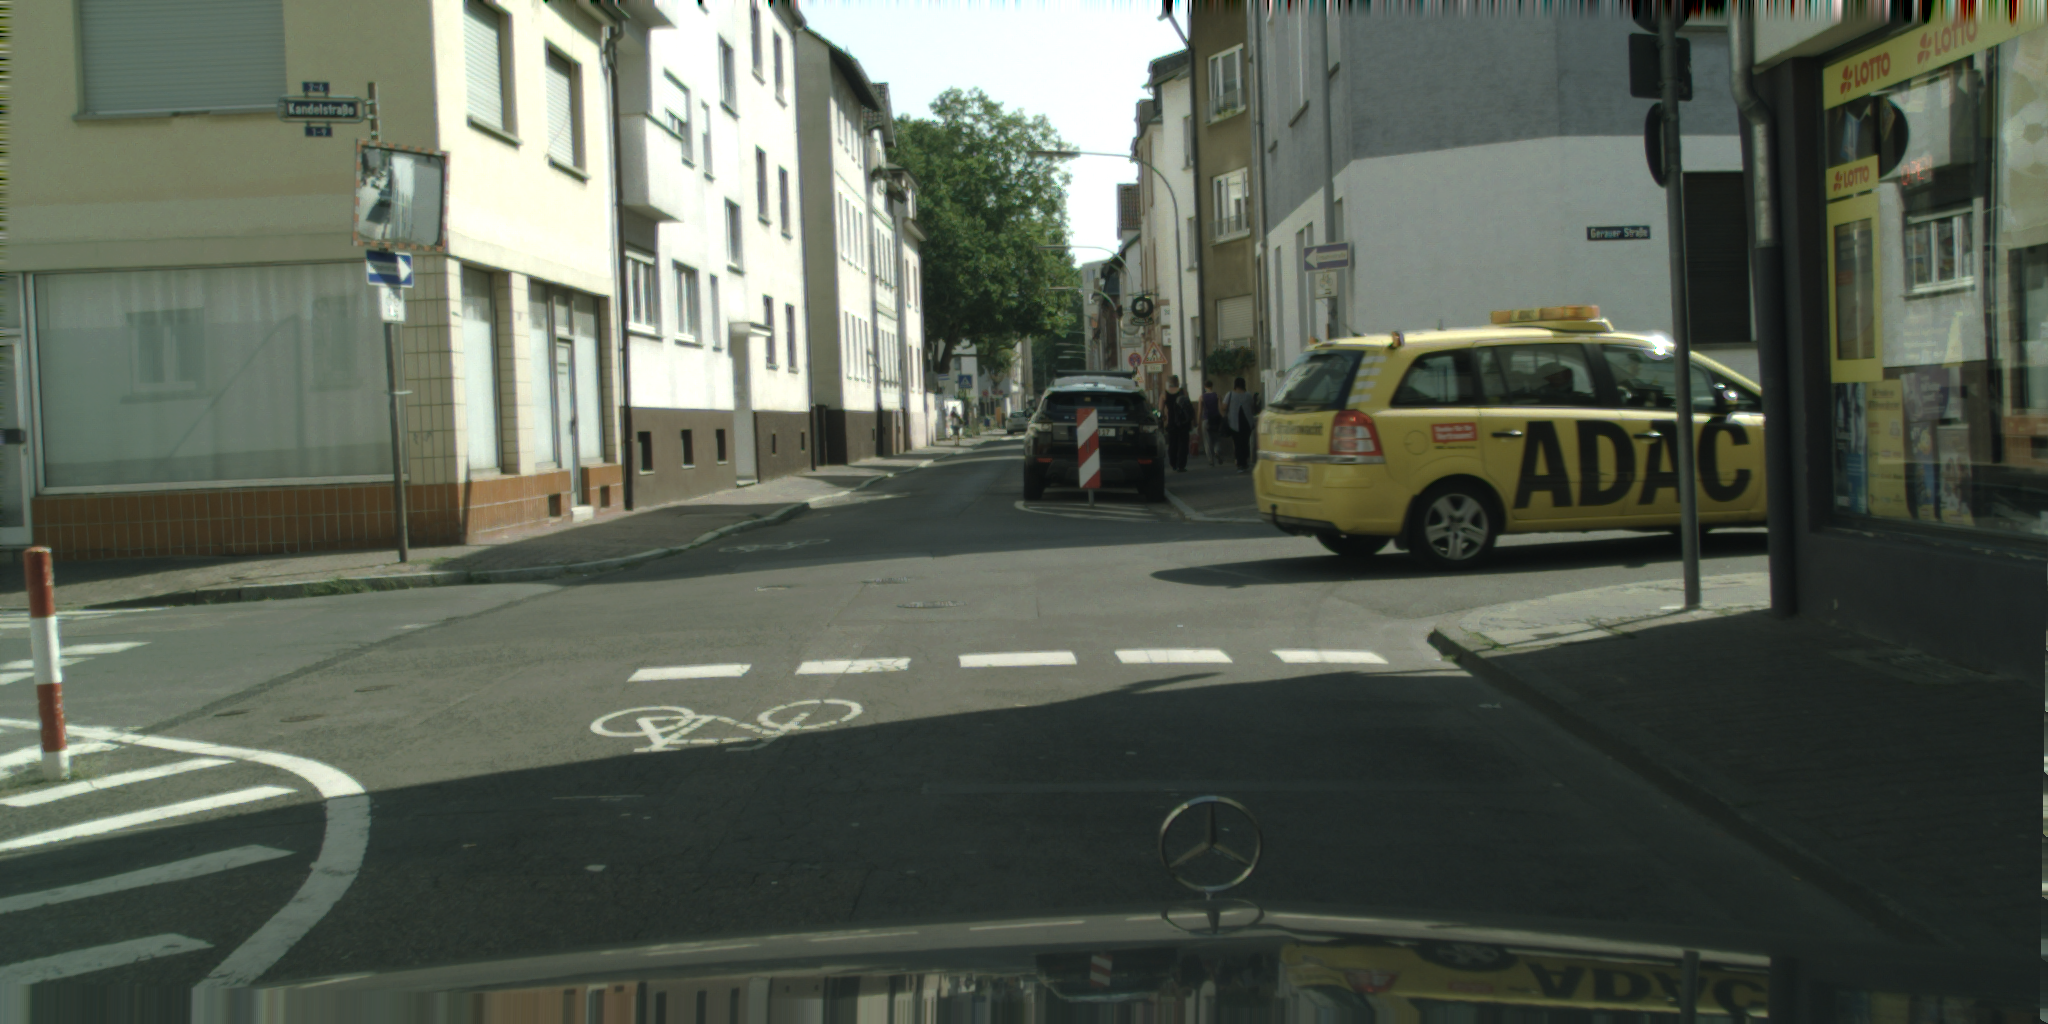

In [41]:
imgp = imgpth[0]
img0 = Img.open(imgp)
img0

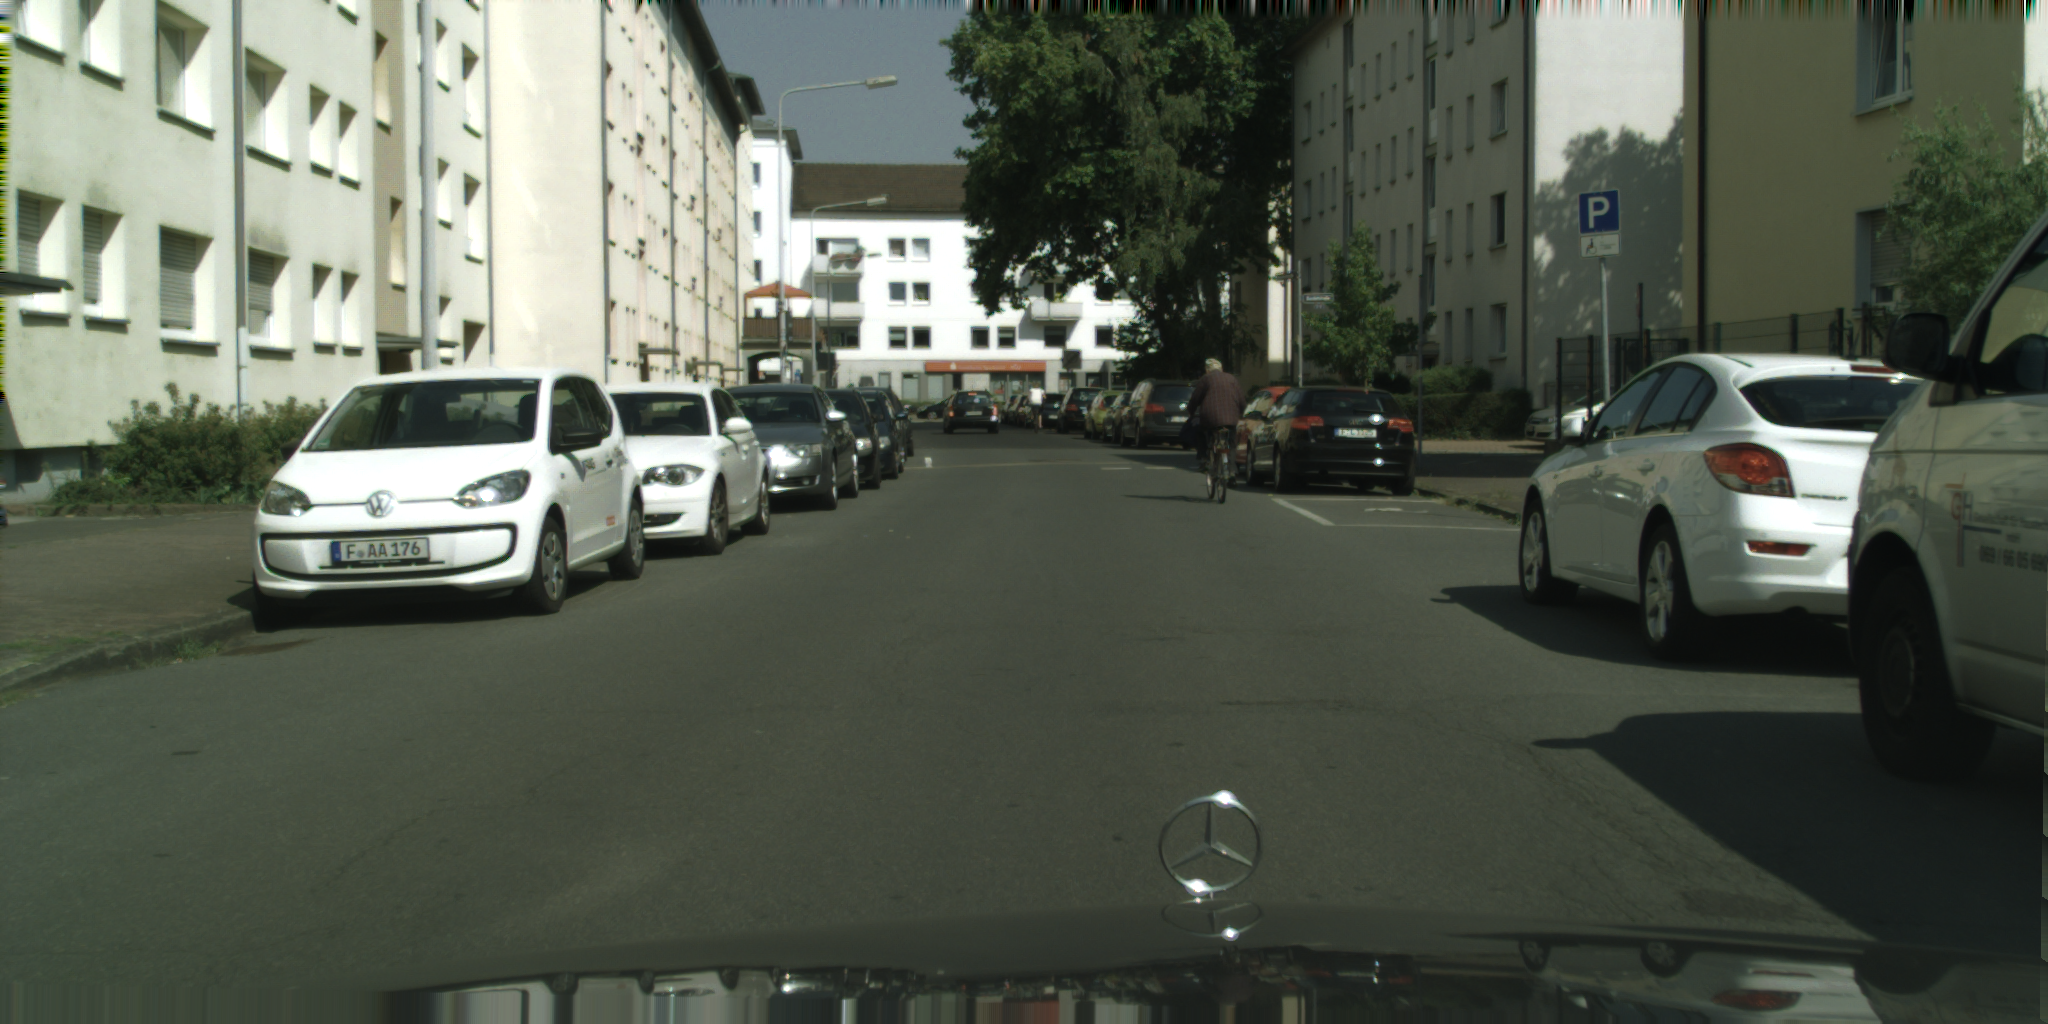

In [46]:
imgp = imgpth[1]
img0 = Img.open(imgp)
img0

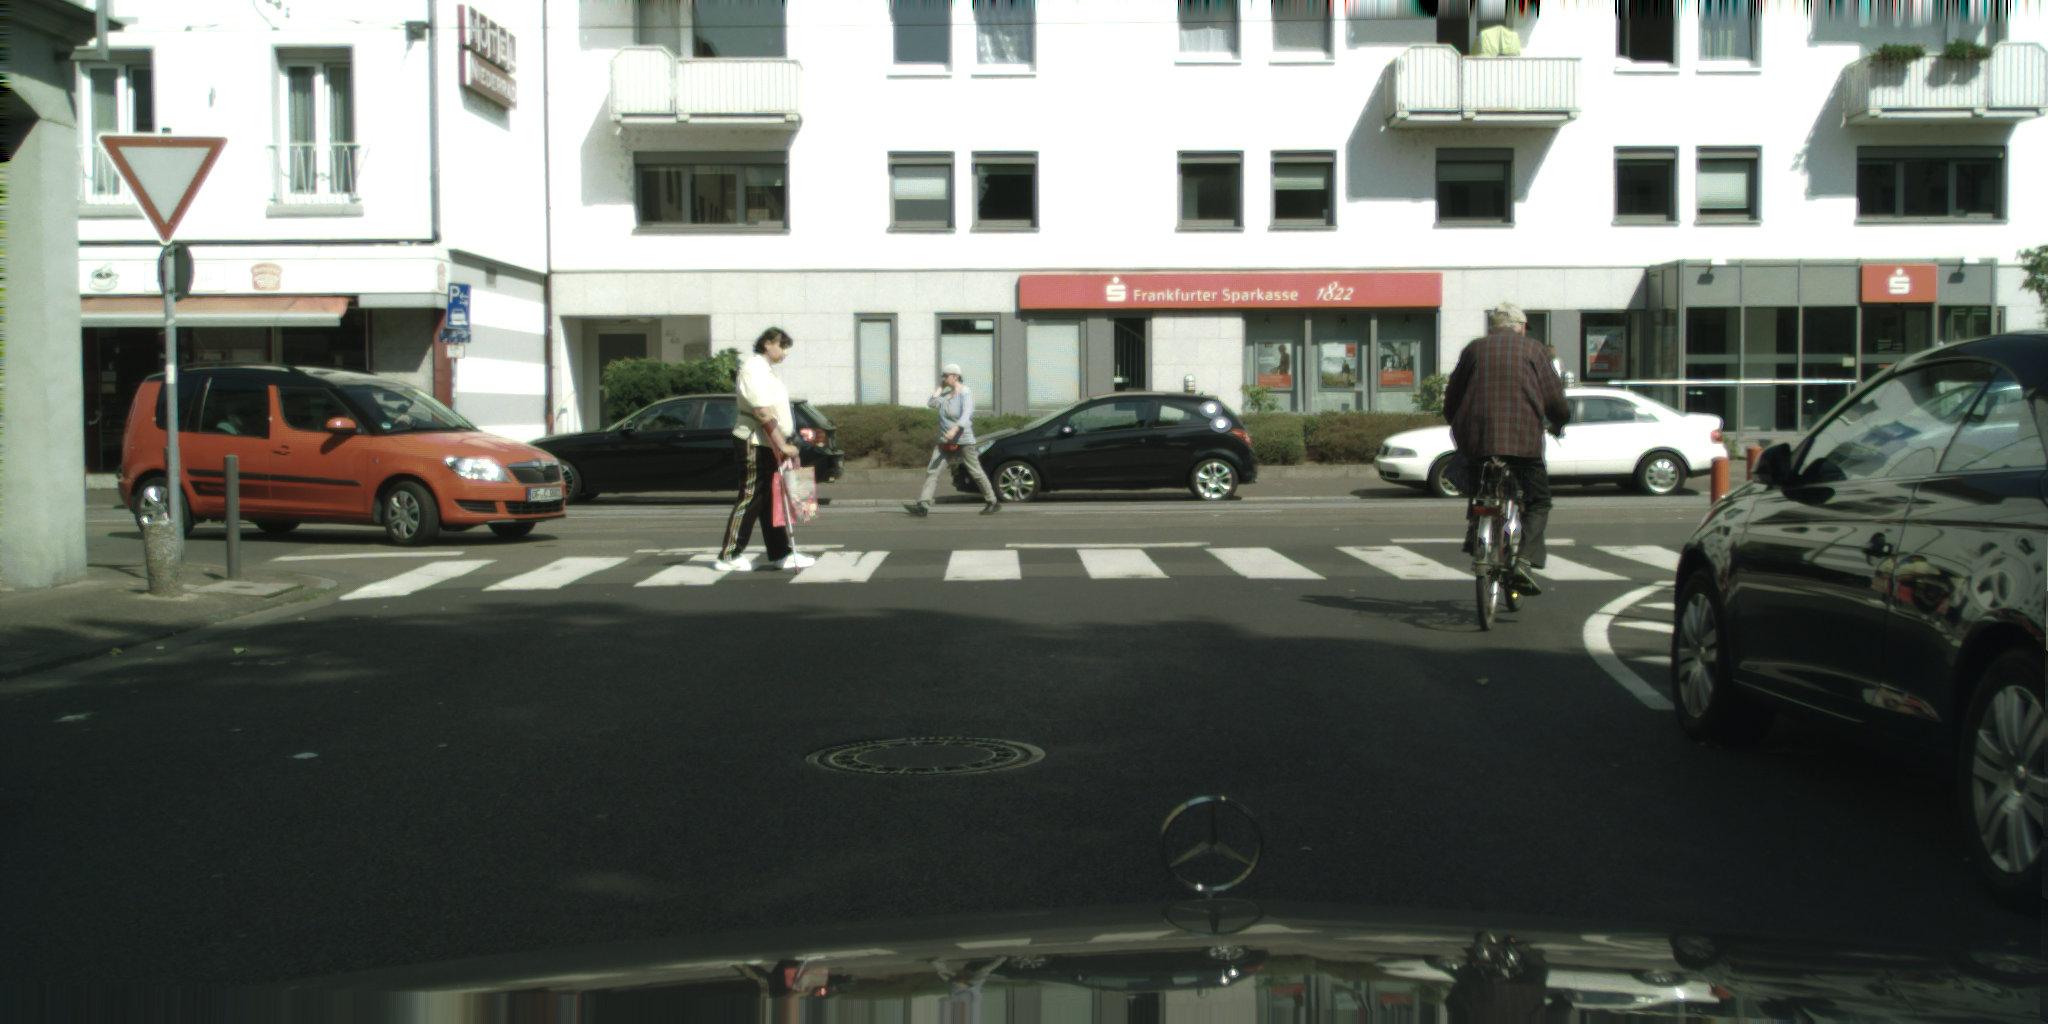

In [54]:
imgp = imgpth[2]
img0 = Img.open(imgp)
img0

In [55]:

img0 = img0.convert('RGB')
img0 = to_tensor(img0)
img0 = img0.unsqueeze(0)

In [56]:
N, C, H, W = img0.size()
scale=0.5
new_hw = [int(H*scale), int(W*scale)]

img0 = F.interpolate(img0, new_hw, mode='bilinear', align_corners=True)

img0.size()

torch.Size([1, 3, 512, 1024])

In [57]:
net.eval()
out = net(img0)[0]

In [58]:
save_pic(out,imgp,out_pth)